Dependecies

In [1]:
library(mice)
library(norm)
library(ggplot2)
library(psych)


Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


This package has some major limitations
(for example, it does not work reliably when
the number of variables exceeds 30),
and has been superseded by the norm2 package.


Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




# Dataset
Load and examine the dataset

In [2]:
# Note: data have been manually cleaned somewhat;
# tabs have been coverted to spaces for consistency
raw_data = read.table('pain.dat', sep=' ', header=TRUE, na.strings='.')
raw_data$female = raw_data$female == 1
raw_data$severity = factor(raw_data$severity, levels=1:6, ordered=TRUE)
summary(raw_data)

   female           depress         phydisab       psydisab     severity 
 Mode :logical   Min.   :1.100   Min.   : 5.0   Min.   : 4.80   1   :29  
 FALSE:130       1st Qu.:3.100   1st Qu.: 8.3   1st Qu.: 9.70   2   :30  
 TRUE :180       Median :3.900   Median : 9.9   Median :10.90   3   :43  
                 Mean   :3.792   Mean   :10.0   Mean   :10.95   4   :72  
                 3rd Qu.:4.400   3rd Qu.:11.7   3rd Qu.:12.30   5   :90  
                 Max.   :6.900   Max.   :16.2   Max.   :17.00   6   :30  
                 NA's   :67      NA's   :9      NA's   :4       NA's:16  
      age    
 Min.   : 7  
 1st Qu.:36  
 Median :46  
 Mean   :44  
 3rd Qu.:52  
 Max.   :74  
             

In [3]:
raw_data

female,depress,phydisab,psydisab,severity,age
<lgl>,<dbl>,<dbl>,<dbl>,<ord>,<int>
FALSE,4.5,12.6,9.8,2,44
FALSE,3.2,10.2,10.9,4,52
FALSE,1.8,8.2,10.9,3,35
FALSE,5.7,9.9,9.0,5,7
FALSE,3.9,6.4,9.6,2,34
FALSE,2.2,12.4,12.0,2,43
FALSE,4.4,11.6,9.2,4,26
FALSE,4.9,11.0,11.2,6,51
FALSE,5.2,7.8,10.3,4,33


Get an overview of the missingness pattern

In [4]:
missing_rates = colSums(is.na(raw_data)) / nrow(raw_data)
print(missing_rates)

    female    depress   phydisab   psydisab   severity        age 
0.00000000 0.21612903 0.02903226 0.01290323 0.05161290 0.00000000 


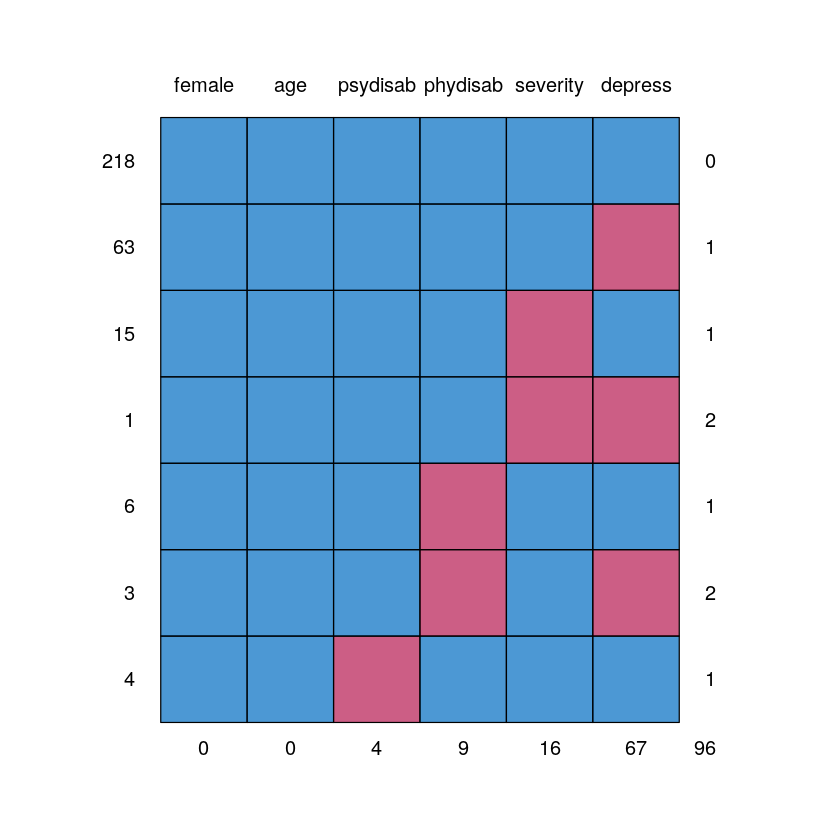

In [5]:
tmp = md.pattern(raw_data)

# Helper Functions
## General
These can be used on any of the datasets

In [6]:
build_linear_model = function(data) {
    with(data, lm(
        depress ~ phydisab + psydisab
        #depress ~ female + phydisab + psydisab + severity + age
    ))
}

In [7]:
plot_residuals = function(model, multiple_datasets=FALSE,
                         append=FALSE, colour='black') {
    
    if (multiple_datasets) {
        residual_val = NULL
        predicted_val = NULL
        for (i in 1:num_imputed_datasets) {
            residual_val = rbind(residual_val,residuals(model$analyses[[i]]))
            model_residuals = colMeans(residual_val)

            predicted_val = rbind(predicted_val,predict(model$analyses[[i]]))
            model_predictions = colMeans(predicted_val)
        }
    } else {
        model_residuals = model$residuals
        model_predictions = model$predictions
    }
    
    if (append) {
        points(model_residuals,model_predictions,xlab='residuals',ylab='predictions',col=colour)
    } else {
        plot(model_residuals,model_predictions,xlab='residuals',ylab='predictions',col=colour)
    }
}

## Listwise Deletion

In [8]:
count_na = function(x) sum(is.na(x))
listwise_deletion = function(data) {
    completeness_mask = apply(data, 1, count_na) == 0
    return(subset(data, completeness_mask))
}

## Multiple Imputation

In [9]:
num_imputed_datasets = 20
num_entries = nrow(raw_data)
CONTINUOUS_COLS = c('depress','phydisab','psydisab','age')

summarize_pooled_results = function(mi_results,
        summary_cols=CONTINUOUS_COLS, mr=missing_rates,
        m=num_imputed_datasets, n=num_entries,
        precision=3) {
    imputed_datasets = complete(mi_results, 'all')

    # Compute the means for each dataset...
    imputed_means = sapply(imputed_datasets, function(dataset) {
        apply(dataset[summary_cols],2,mean)
    })
    
    # ...then combine them...
    grand_means = apply(imputed_means,1,mean)
    
    # ...and compute summary statistics
    
    std_err = sapply(imputed_datasets, function(dataset) {
        apply(dataset[summary_cols],2,sd) / sqrt(n)
    })
    
    within_impute_var = apply(std_err^2,1,mean)
    
    btw_impute_var = rep(NA,length(summary_cols))
    names(btw_impute_var) = names(within_impute_var)

    for (j in 1:nrow(imputed_means)) {
        btw_impute_var[j] = sum((imputed_means[j,] -
            grand_means[j])^2 / (m - 1))
    }

    total_var = within_impute_var + btw_impute_var +
        btw_impute_var / m
    total_std_err = sqrt(total_var)
    
    fmi = (btw_impute_var + btw_impute_var/m) / total_std_err
    
    pooled_stats = round(data.frame(
        mean=grand_means,Vw=within_impute_var,Vb=btw_impute_var,
        SE=total_std_err,Vt=total_var,FMI=fmi,MR=mr[summary_cols]),precision)
    
    return(pooled_stats)
}

## Maximum Likelihood Estimation

In [10]:
# Initialize psuedo-random number generator in a reasonably
# unpredictable way
set.seed(as.numeric(Sys.time()))

In [11]:
# Estimate mean, standard deviation, covariance matrix, and correlation
em = function(data, cols=NULL) {
    if (is.null(cols)) {
        cols = names(data)
    }
    
    summary = prelim.norm(data.matrix(data[cols]))
    results_vec = em.norm(summary, showits=FALSE)
    return(getparam.norm(summary, results_vec, corr=TRUE))
}

get_covariance = function(em_results) {
    std_dev = diag(em_results$sdv)
    return(std_dev %*% em_results$r %*% std_dev)
}

# Estimate regression coeffecients, based on example in Likelihood.R
coeff_em = function(data, em_results, indep_col, predictor_cols=NULL,
                   offset=0) {
    if (is.null(predictor_cols)) {
        predictor_cols = data[-indep_col]
    }
    
    covariance = get_covariance(em_results)
    
    covariance_dep = covariance[predictor_cols, predictor_cols]
    covariance_mixed = covariance[predictor_cols, indep_col]
    coeffs = solve(covariance_dep) %*% covariance_mixed
    
    intercept = em_results$mu[indep_col] -
        sum(coeffs * em_results$mu[predictor_cols])
    coeffs = rbind(c(intercept), coeffs)
    
    rownames(coeffs) = append(c('(Intercept)'), colnames(data)[offset+predictor_cols])
    
    return(data.frame(coeffs))
}

# Analysis

## Full Data

Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphic

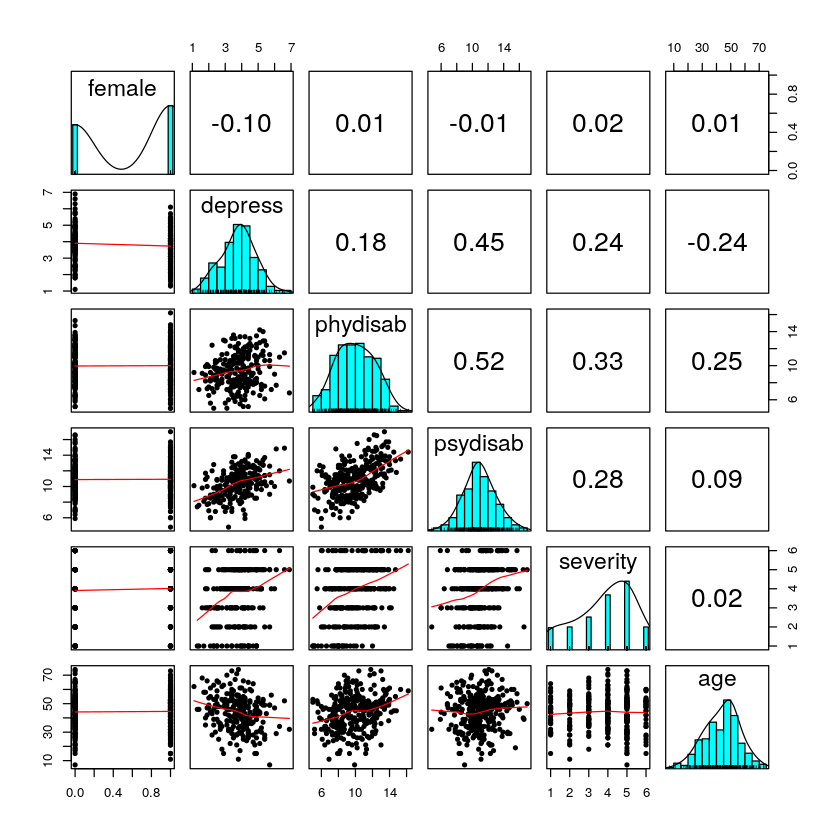

In [12]:
pairs.panels(raw_data,ellipses=FALSE)

### Model Building
#### Listwise Deletion

In [13]:
complete_case_data = listwise_deletion(raw_data)
summary(complete_case_data)

   female           depress         phydisab        psydisab     severity
 Mode :logical   Min.   :1.400   Min.   : 5.00   Min.   : 4.80   1:23    
 FALSE:96        1st Qu.:3.200   1st Qu.: 7.90   1st Qu.: 9.20   2:25    
 TRUE :122       Median :3.900   Median : 9.30   Median :10.60   3:38    
                 Mean   :3.811   Mean   : 9.35   Mean   :10.37   4:54    
                 3rd Qu.:4.400   3rd Qu.:10.80   3rd Qu.:11.40   5:63    
                 Max.   :6.900   Max.   :14.20   Max.   :14.90   6:15    
      age      
 Min.   : 7.0  
 1st Qu.:34.0  
 Median :43.5  
 Mean   :43.0  
 3rd Qu.:52.0  
 Max.   :74.0  

In [14]:
complete_case_model = build_linear_model(complete_case_data)
summary(complete_case_model)


Call:
lm(formula = depress ~ phydisab + psydisab)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.34069 -0.58748 -0.03562  0.64162  3.01971 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.212426   0.417620   2.903  0.00408 ** 
phydisab    0.004489   0.033406   0.134  0.89323    
psydisab    0.246480   0.037646   6.547 4.24e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9172 on 215 degrees of freedom
Multiple R-squared:  0.1844,	Adjusted R-squared:  0.1769 
F-statistic: 24.31 on 2 and 215 DF,  p-value: 3.031e-10


#### Multiple Imputation

In [15]:
mi_data = mice(raw_data, m=num_imputed_datasets, maxit=20, seed=664,
    defaultMethod=c('norm.nob','logreg','lda','polr'))


 iter imp variable
  1   1  depress  phydisab  psydisab  severity
  1   2  depress  phydisab  psydisab  severity
  1   3  depress  phydisab  psydisab  severity
  1   4  depress  phydisab  psydisab  severity
  1   5  depress  phydisab  psydisab  severity
  1   6  depress  phydisab  psydisab  severity
  1   7  depress  phydisab  psydisab  severity
  1   8  depress  phydisab  psydisab  severity
  1   9  depress  phydisab  psydisab  severity
  1   10  depress  phydisab  psydisab  severity
  1   11  depress  phydisab  psydisab  severity
  1   12  depress  phydisab  psydisab  severity
  1   13  depress  phydisab  psydisab  severity
  1   14  depress  phydisab  psydisab  severity
  1   15  depress  phydisab  psydisab  severity
  1   16  depress  phydisab  psydisab  severity
  1   17  depress  phydisab  psydisab  severity
  1   18  depress  phydisab  psydisab  severity
  1   19  depress  phydisab  psydisab  severity
  1   20  depress  phydisab  psydisab  severity
  2   1  depress  phydisab  p

In [16]:
summarize_pooled_results(mi_data, precision=5)

,mean,Vw,Vb,SE,Vt,FMI,MR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
depress,3.96434,0.00386,0.00031,0.06473,0.00419,0.00508,0.21613
phydisab,9.98785,0.01606,0.00014,0.12729,0.01620,0.00114,0.02903
psydisab,10.93652,0.01383,0.00006,0.11790,0.01390,0.00056,0.01290
age,44.00000,0.48798,0.00000,0.69856,0.48798,0.00000,0.00000


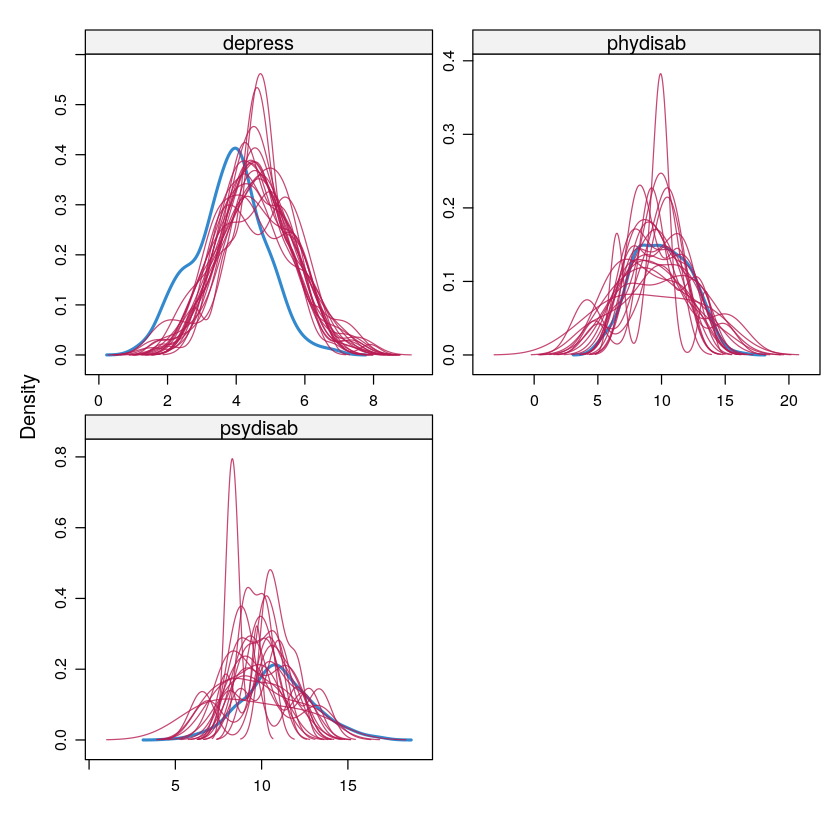

In [17]:
densityplot(mi_data)

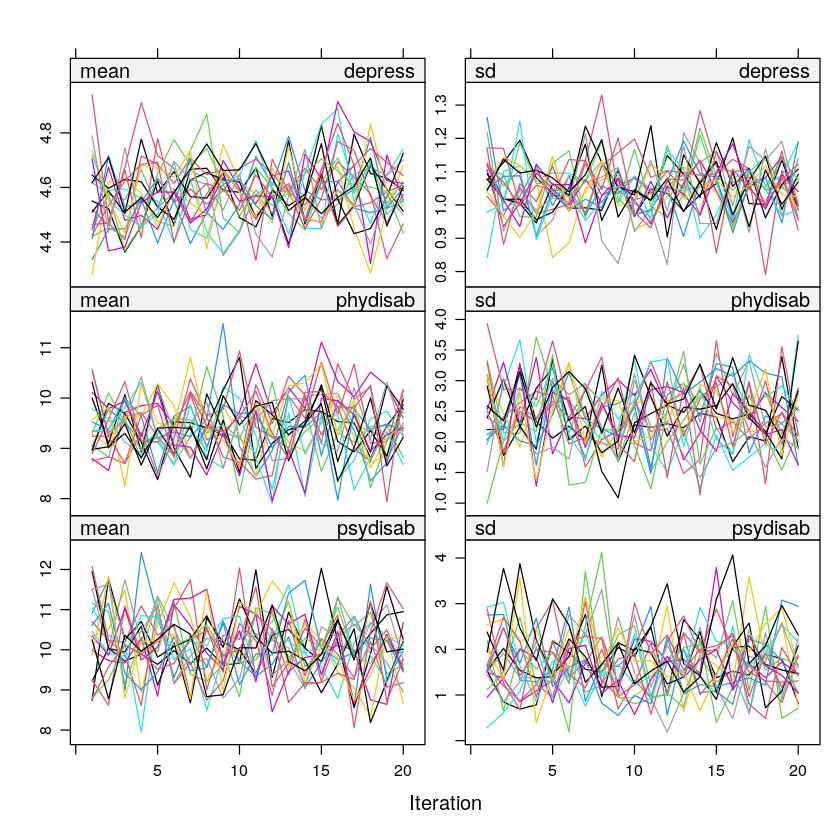

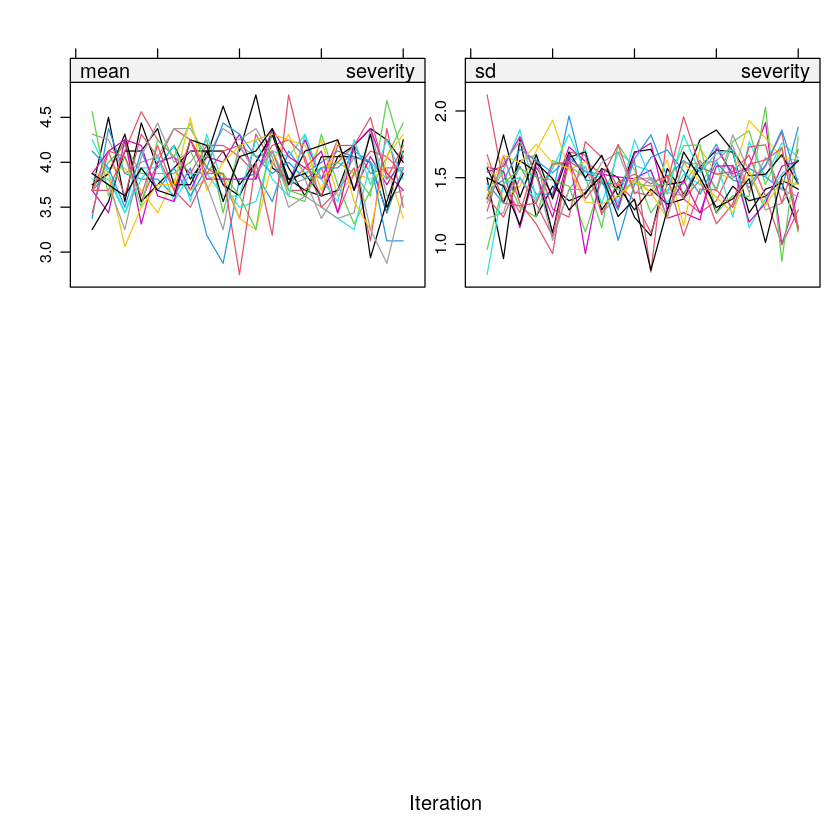

In [18]:
plot(mi_data)

In [19]:
mi_model = build_linear_model(mi_data)
summary(pool(mi_model))

term,estimate,std.error,statistic,df,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.85143389,0.33776054,2.5208211,168.4216,1.263750e-02
phydisab,0.01975861,0.03028996,0.6523155,199.7778,5.149475e-01
psydisab,0.26658773,0.03275486,8.1388759,194.6392,4.662937e-14


#### Maximum Likelihood Estimation

In [20]:
em_results = em(raw_data, cols=c('depress','phydisab','psydisab'))
em_results

1.0000000,0.2943664,0.5156738
0.2943664,1.0000000,0.5211676
0.5156738,0.5211676,1.0000000


### Results
#### Listwise Deletion

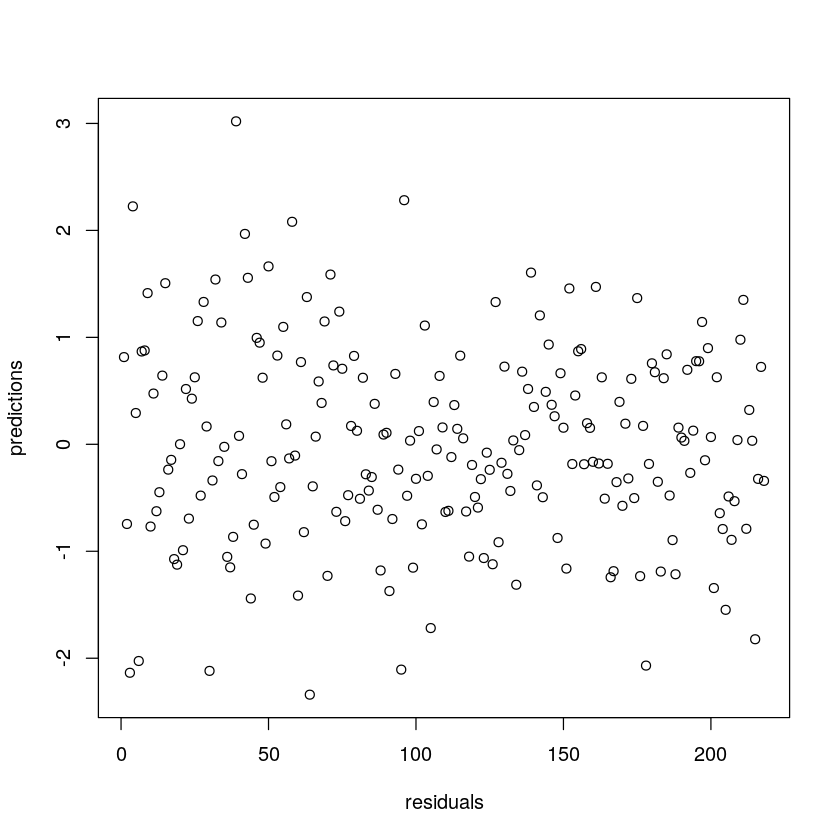

In [21]:
plot_residuals(complete_case_model)

#### Multiple Imputation

In [22]:
pool.r.squared(mi_model,adjusted=TRUE)

,est,lo 95,hi 95,fmi
adj R^2,0.2736203,0.1825317,0.3688258,0.1900508


In [23]:
tidy(pool(mi_model),conf.int=TRUE)

term,estimate,std.error,statistic,p.value,conf.low,conf.high,b,df,dfcom,fmi,lambda,m,riv,ubar
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
(Intercept),0.85143389,0.33776054,2.5208211,1.263750e-02,0.18464414,1.51822363,0.0205998197,168.4216,307,0.1990536,0.1895985,20,0.2339563,0.0924523715
phydisab,0.01975861,0.03028996,0.6523155,5.149475e-01,-0.03997046,0.07948768,0.0001295271,199.7778,307,0.1566365,0.1482355,20,0.1740335,0.0007814785
psydisab,0.26658773,0.03275486,8.1388759,4.662937e-14,0.20198772,0.33118774,0.0001580538,194.6392,307,0.1632372,0.1546831,20,0.1829883,0.0009069242


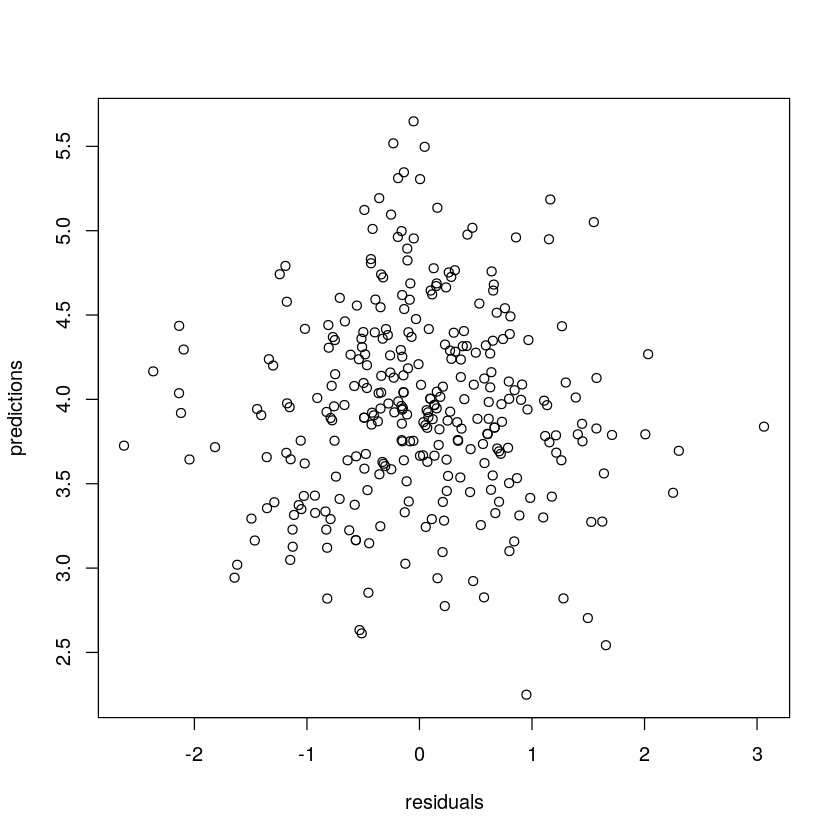

In [24]:
plot_residuals(mi_model, multiple_datasets=TRUE)

#### Maximum Likelihood Estimation

In [25]:
em_model_coeffs = coeff_em(raw_data, em_results, 1, predictor_cols=c(2,3),offset=1)
em_model_coeffs

,coeffs
,<dbl>
(Intercept),0.92675777
phydisab,0.01716625
psydisab,0.26048918


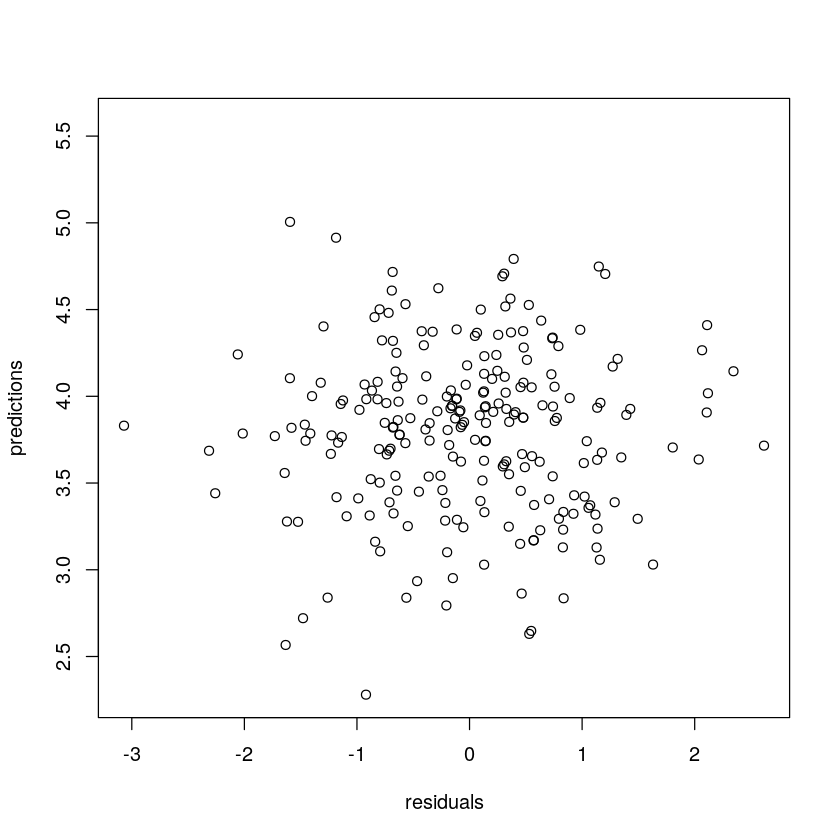

In [26]:
em_model_predictions = em_model_coeffs$coeffs[1] +
    em_model_coeffs$coeffs[2]*raw_data$phydisab +
    em_model_coeffs$coeffs[3]*raw_data$psydisab
em_model_residuals = em_model_predictions - raw_data$depress

plot(em_model_residuals,em_model_predictions,
     xlab='residuals',ylab='predictions')

## Stratification
Gender is suspected to modify associations, so let's try stratifying by those

In [27]:
# No need to record gender in gender-stratified data
raw_female_data = subset(raw_data,raw_data$female)[-1]
raw_male_data = subset(raw_data,!raw_data$female)[-1]

## Women Only

Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphic

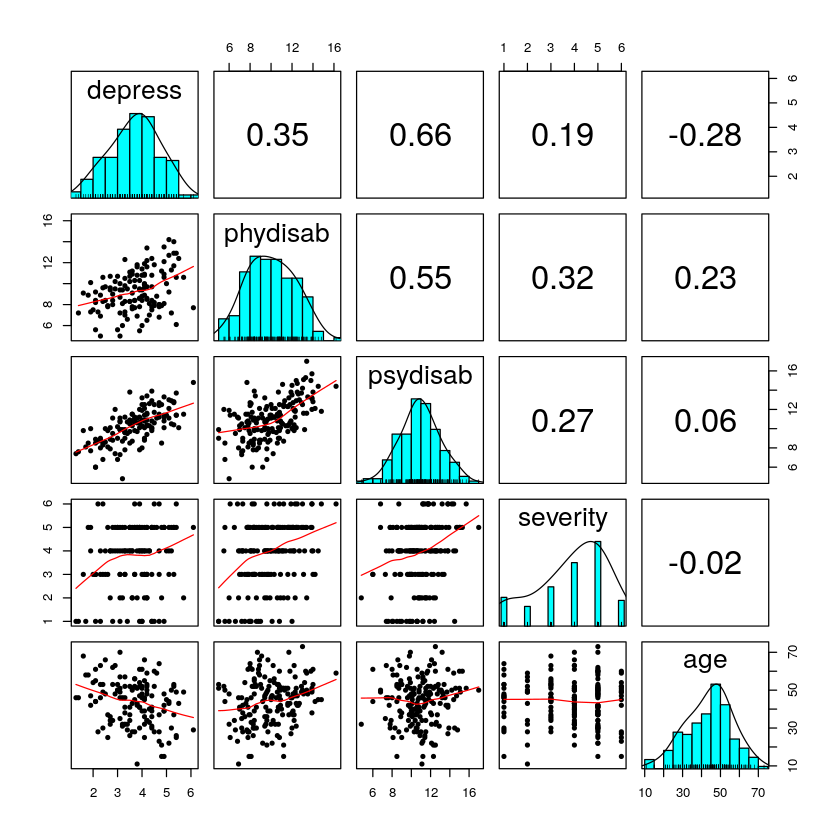

In [28]:
pairs.panels(raw_female_data,ellipses=FALSE)

### Model Building
#### Listwise Deletion

In [29]:
complete_case_female_data = listwise_deletion(raw_female_data)
summary(complete_case_female_data)

    depress        phydisab         psydisab     severity      age       
 Min.   :1.40   Min.   : 5.000   Min.   : 4.80   1:14     Min.   :11.00  
 1st Qu.:3.10   1st Qu.: 7.900   1st Qu.: 9.00   2:11     1st Qu.:34.00  
 Median :3.85   Median : 9.050   Median :10.45   3:23     Median :44.00  
 Mean   :3.73   Mean   : 9.135   Mean   :10.29   4:30     Mean   :42.93  
 3rd Qu.:4.40   3rd Qu.:10.450   3rd Qu.:11.40   5:38     3rd Qu.:52.00  
 Max.   :6.10   Max.   :14.200   Max.   :14.80   6: 6     Max.   :70.00  

In [30]:
complete_case_model = build_linear_model(complete_case_female_data)
summary(complete_case_model)


Call:
lm(formula = depress ~ phydisab + psydisab)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.96075 -0.44103 -0.04632  0.46454  1.76360 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.39577    0.45141  -0.877   0.3824    
phydisab     0.06875    0.03730   1.843   0.0678 .  
psydisab     0.33988    0.03983   8.533  5.4e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7359 on 119 degrees of freedom
Multiple R-squared:  0.4425,	Adjusted R-squared:  0.4332 
F-statistic: 47.23 on 2 and 119 DF,  p-value: 7.938e-16


#### Multiple Imputation

In [31]:
mi_female_data = mice(raw_female_data, m=num_imputed_datasets, maxit=20, seed=664,
    defaultMethod=c('norm.nob','logreg','lda','polr'))


 iter imp variable
  1   1  depress  phydisab  psydisab  severity
  1   2  depress  phydisab  psydisab  severity
  1   3  depress  phydisab  psydisab  severity
  1   4  depress  phydisab  psydisab  severity
  1   5  depress  phydisab  psydisab  severity
  1   6  depress  phydisab  psydisab  severity
  1   7  depress  phydisab  psydisab  severity
  1   8  depress  phydisab  psydisab  severity
  1   9  depress  phydisab  psydisab  severity
  1   10  depress  phydisab  psydisab  severity
  1   11  depress  phydisab  psydisab  severity
  1   12  depress  phydisab  psydisab  severity
  1   13  depress  phydisab  psydisab  severity
  1   14  depress  phydisab  psydisab  severity
  1   15  depress  phydisab  psydisab  severity
  1   16  depress  phydisab  psydisab  severity
  1   17  depress  phydisab  psydisab  severity
  1   18  depress  phydisab  psydisab  severity
  1   19  depress  phydisab  psydisab  severity
  1   20  depress  phydisab  psydisab  severity
  2   1  depress  phydisab  p

In [32]:
summarize_pooled_results(mi_female_data, precision=5)

,mean,Vw,Vb,SE,Vt,FMI,MR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
depress,4.00106,0.00413,0.00054,0.06858,0.00470,0.00830,0.21613
phydisab,9.97183,0.01692,0.00041,0.13173,0.01735,0.00327,0.02903
psydisab,10.91831,0.01386,0.00021,0.11866,0.01408,0.00186,0.01290
age,44.13889,0.46566,0.00000,0.68239,0.46566,0.00000,0.00000


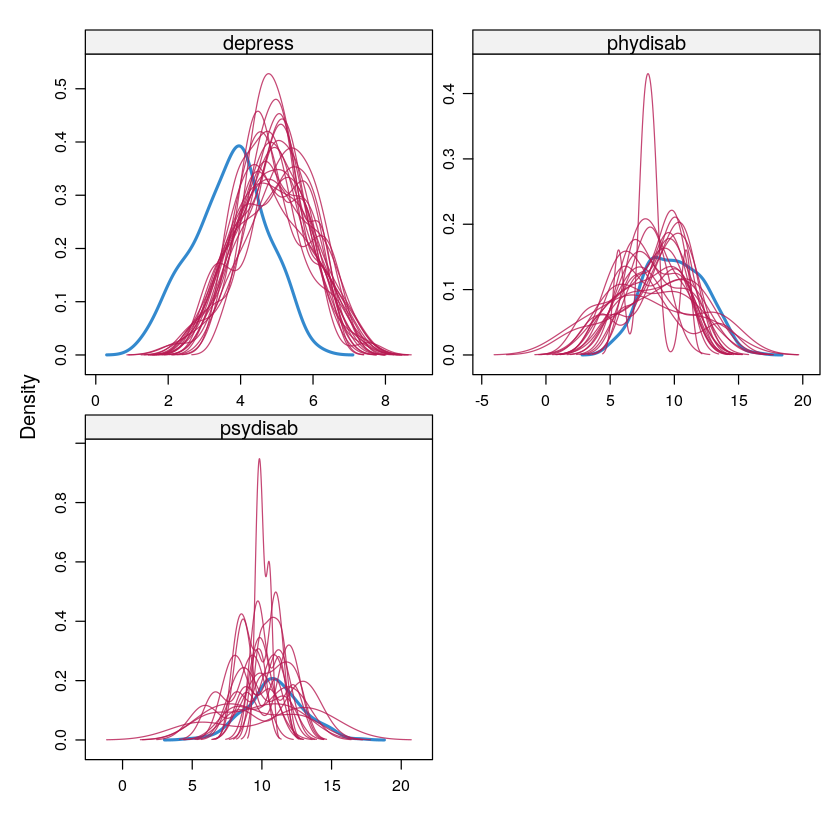

In [33]:
densityplot(mi_female_data)

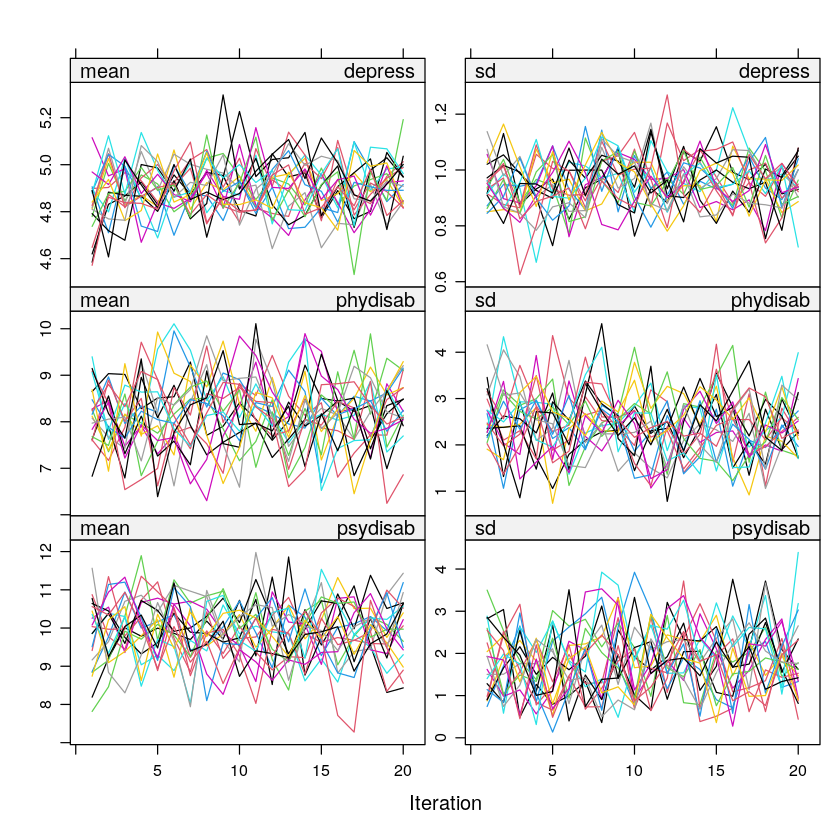

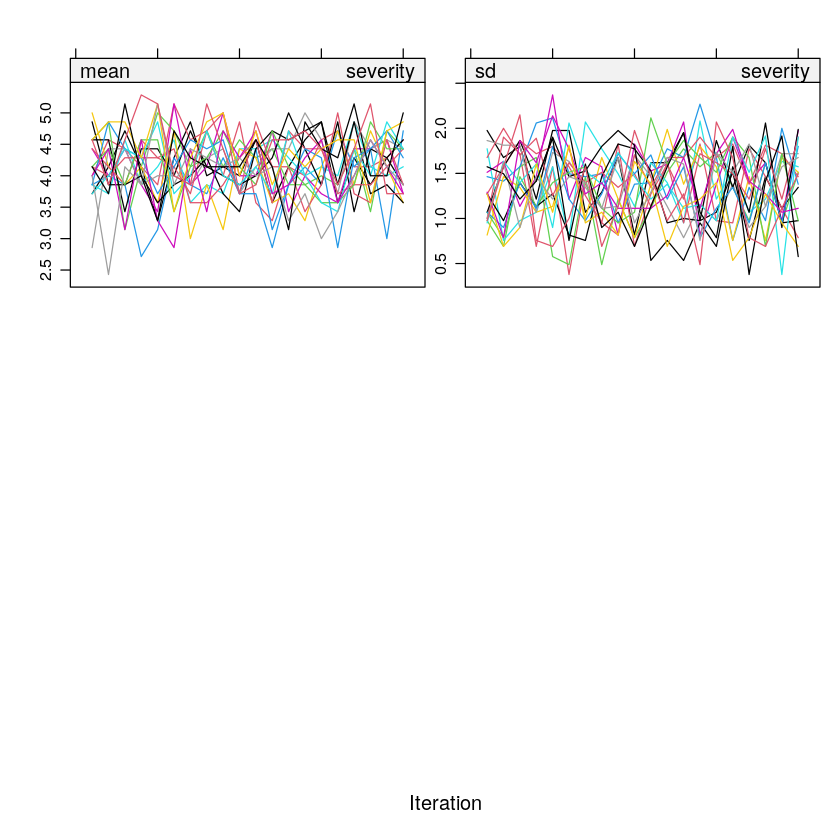

In [34]:
plot(mi_female_data)

In [35]:
mi_model = build_linear_model(mi_female_data)
summary(pool(mi_model))

term,estimate,std.error,statistic,df,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.63813815,0.36591909,-1.743932,94.53735,8.442141e-02
phydisab,0.08650737,0.03545211,2.440119,79.23745,1.691483e-02
psydisab,0.34589929,0.03661844,9.446042,111.12588,6.661338e-16


#### Maximum Likelihood Estimation

In [36]:
em_results = em(raw_female_data, cols=c('depress','phydisab','psydisab'))
em_results

1.0000000,0.5201433,0.7350944
0.5201433,1.0000000,0.5554629
0.7350944,0.5554629,1.0000000


### Results
#### Listwise Deletion

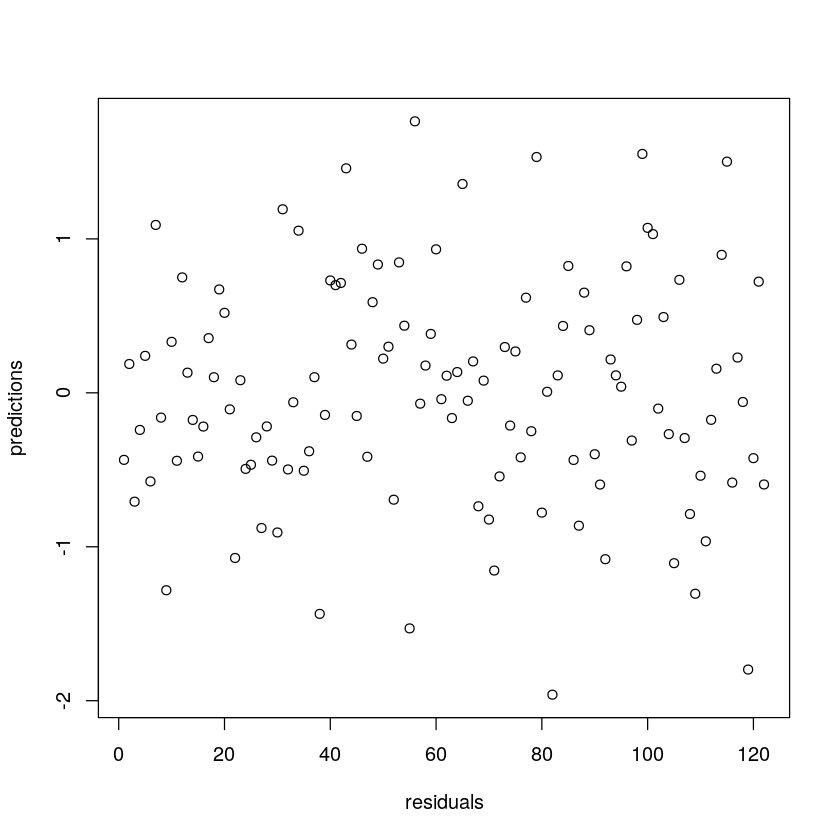

In [37]:
plot_residuals(complete_case_model)

#### Multiple Imputation

In [38]:
pool.r.squared(mi_model,adjusted=TRUE)

,est,lo 95,hi 95,fmi
adj R^2,0.5515397,0.4366008,0.6513804,0.1779015


In [39]:
tidy(pool(mi_model),conf.int=TRUE)

term,estimate,std.error,statistic,p.value,conf.low,conf.high,b,df,dfcom,fmi,lambda,m,riv,ubar
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
(Intercept),-0.63813815,0.36591909,-1.743932,8.442141e-02,-1.3646252,0.08834894,0.0307095990,94.53735,177,0.2563874,0.2408204,20,0.3172114,0.10165170
phydisab,0.08650737,0.03545211,2.440119,1.691483e-02,0.0159450,0.15706975,0.0003513165,79.23745,177,0.3106790,0.2934970,20,0.4154221,0.00088797
psydisab,0.34589929,0.03661844,9.446042,6.661338e-16,0.2733383,0.41846026,0.0002446567,111.12588,177,0.2057457,0.1915785,20,0.2369785,0.00108402


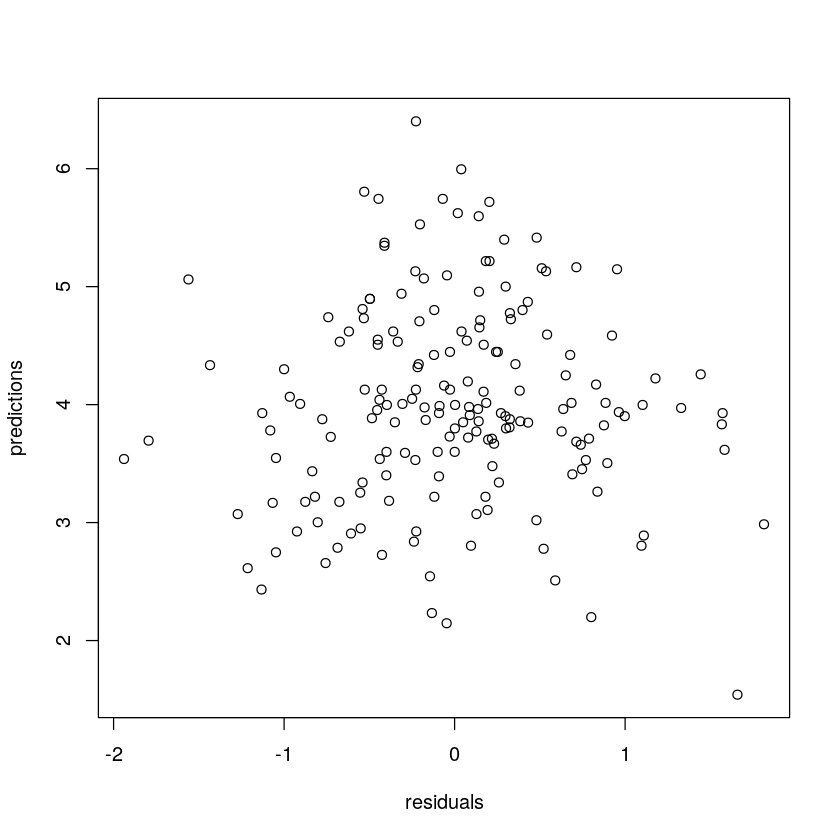

In [40]:
plot_residuals(mi_model, multiple_datasets=TRUE)

#### Maximum Likelihood Estimation

In [41]:
em_model_coeffs = coeff_em(raw_female_data, em_results, 1, predictor_cols=c(2,3),offset=1)
em_model_coeffs

,coeffs
,<dbl>
(Intercept),-0.61799808
psydisab,0.07967956
severity,0.34828550


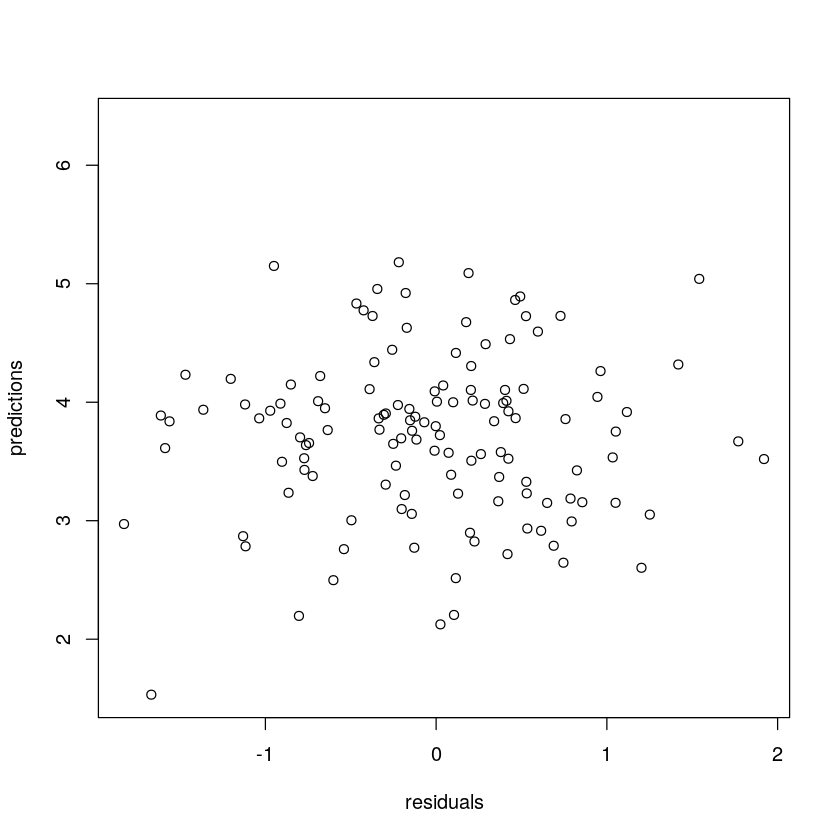

In [42]:
em_model_predictions = em_model_coeffs$coeffs[1] +
    em_model_coeffs$coeffs[2]*raw_female_data$phydisab +
    em_model_coeffs$coeffs[3]*raw_female_data$psydisab
em_model_residuals = em_model_predictions - raw_female_data$depress

plot(em_model_residuals,em_model_predictions,
     xlab='residuals',ylab='predictions')

## ## Men Only

Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphical parameter”
Warning message in par(usr):
“argument 1 does not name a graphic

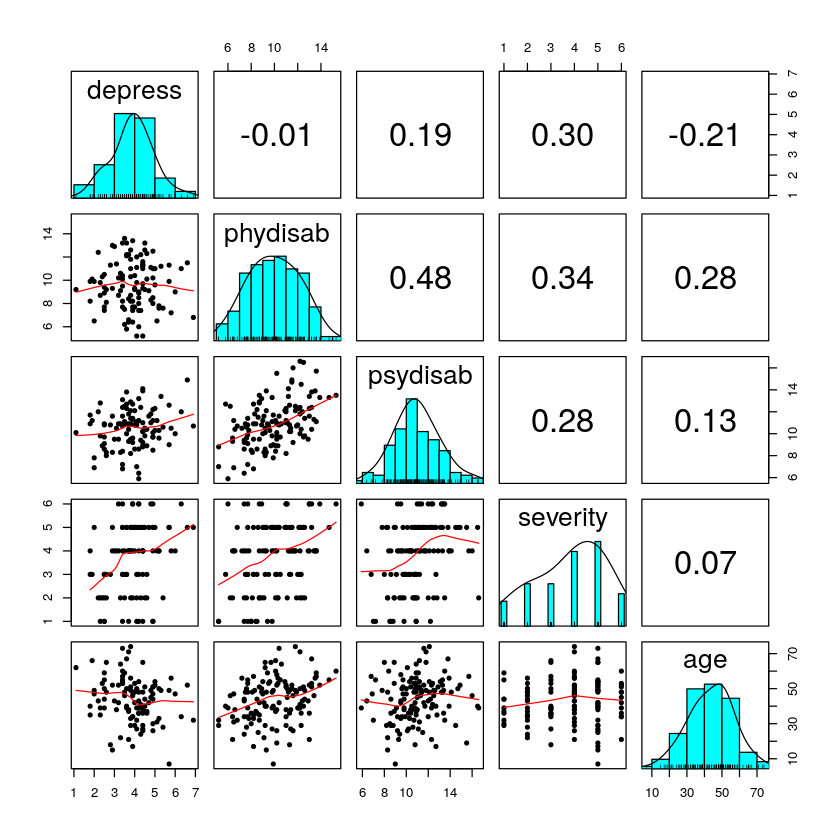

In [43]:
pairs.panels(raw_male_data,ellipses=FALSE)

### Model Building
#### Listwise Deletion

In [44]:
complete_case_male_data = listwise_deletion(raw_male_data)
summary(complete_case_male_data)

    depress         phydisab         psydisab      severity      age       
 Min.   :1.800   Min.   : 5.200   Min.   : 5.900   1: 9     Min.   : 7.00  
 1st Qu.:3.400   1st Qu.: 8.075   1st Qu.: 9.275   2:14     1st Qu.:35.00  
 Median :3.900   Median : 9.600   Median :10.750   3:15     Median :43.00  
 Mean   :3.914   Mean   : 9.623   Mean   :10.475   4:24     Mean   :43.10  
 3rd Qu.:4.400   3rd Qu.:11.225   3rd Qu.:11.600   5:25     3rd Qu.:51.25  
 Max.   :6.900   Max.   :13.600   Max.   :14.900   6: 9     Max.   :74.00  

In [45]:
complete_case_model = build_linear_model(complete_case_male_data)
summary(complete_case_model)


Call:
lm(formula = depress ~ phydisab + psydisab)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2562 -0.5991 -0.0817  0.6325  2.7776 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.27699    0.71539   4.581 1.44e-05 ***
phydisab    -0.06443    0.05523  -1.166    0.246    
psydisab     0.11995    0.06543   1.833    0.070 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.039 on 93 degrees of freedom
Multiple R-squared:  0.0381,	Adjusted R-squared:  0.01742 
F-statistic: 1.842 on 2 and 93 DF,  p-value: 0.1643


#### Multiple Imputation

In [46]:
mi_male_data = mice(raw_male_data, m=num_imputed_datasets, maxit=20, seed=664,
    defaultMethod=c('norm.nob','logreg','lda','polr'))


 iter imp variable
  1   1  depress  phydisab  psydisab  severity
  1   2  depress  phydisab  psydisab  severity
  1   3  depress  phydisab  psydisab  severity
  1   4  depress  phydisab  psydisab  severity
  1   5  depress  phydisab  psydisab  severity
  1   6  depress  phydisab  psydisab  severity
  1   7  depress  phydisab  psydisab  severity
  1   8  depress  phydisab  psydisab  severity
  1   9  depress  phydisab  psydisab  severity
  1   10  depress  phydisab  psydisab  severity
  1   11  depress  phydisab  psydisab  severity
  1   12  depress  phydisab  psydisab  severity
  1   13  depress  phydisab  psydisab  severity
  1   14  depress  phydisab  psydisab  severity
  1   15  depress  phydisab  psydisab  severity
  1   16  depress  phydisab  psydisab  severity
  1   17  depress  phydisab  psydisab  severity
  1   18  depress  phydisab  psydisab  severity
  1   19  depress  phydisab  psydisab  severity
  1   20  depress  phydisab  psydisab  severity
  2   1  depress  phydisab  p

In [47]:
summarize_pooled_results(mi_male_data, precision=5)

,mean,Vw,Vb,SE,Vt,FMI,MR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
depress,3.96616,0.00385,0.00089,0.06911,0.00478,0.01347,0.21613
phydisab,9.98793,0.01543,0.00069,0.12709,0.01615,0.00568,0.02903
psydisab,10.96462,0.01398,0.00022,0.11919,0.01421,0.00192,0.01290
age,43.80769,0.52254,0.00000,0.72287,0.52254,0.00000,0.00000


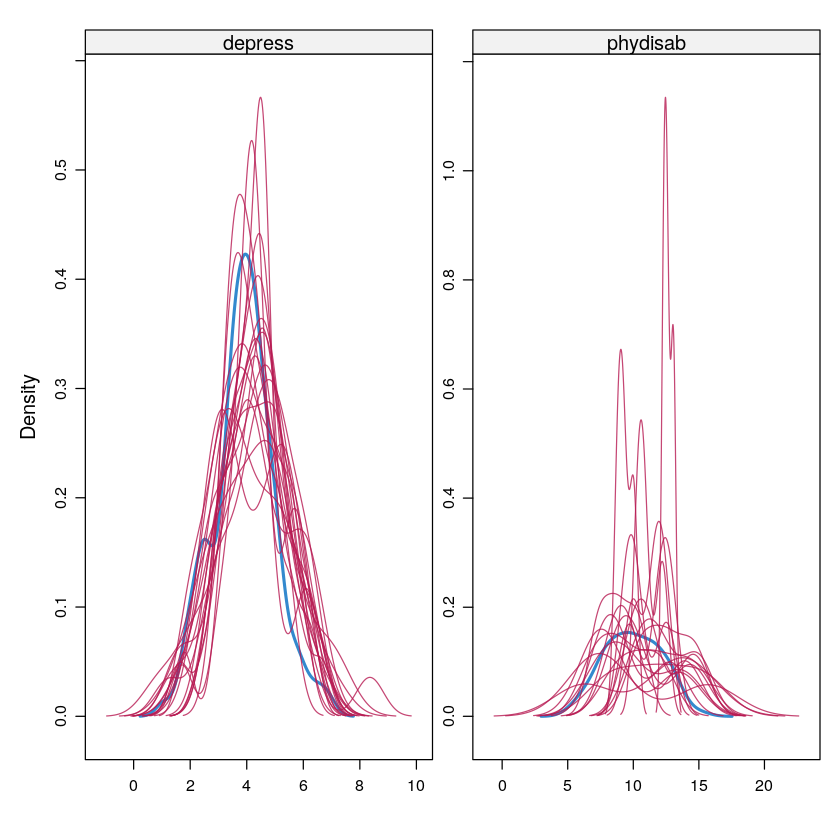

In [48]:
densityplot(mi_male_data)

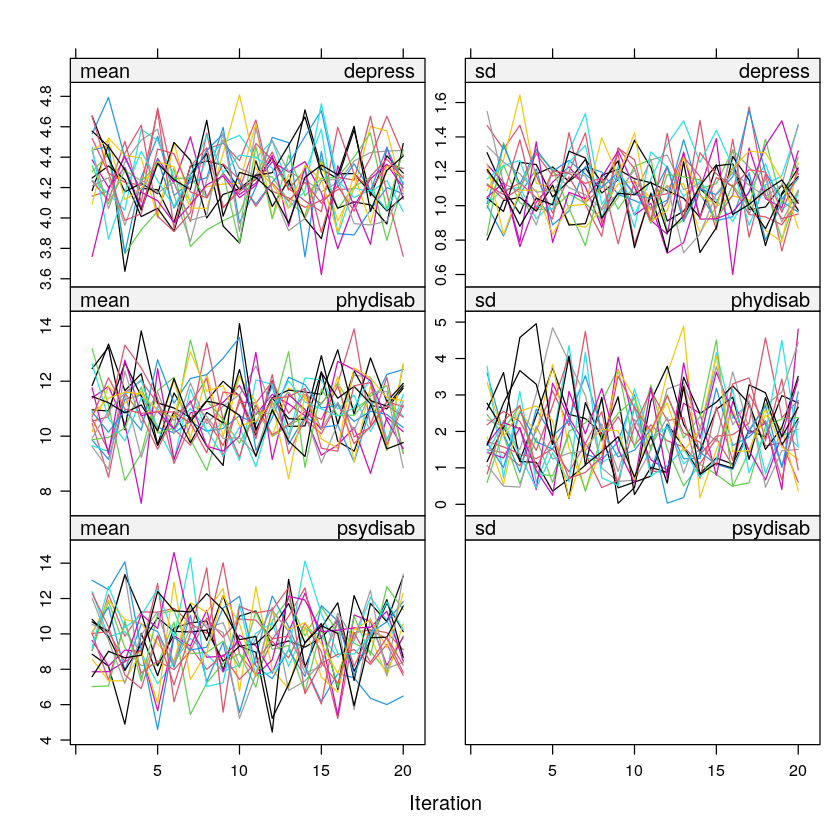

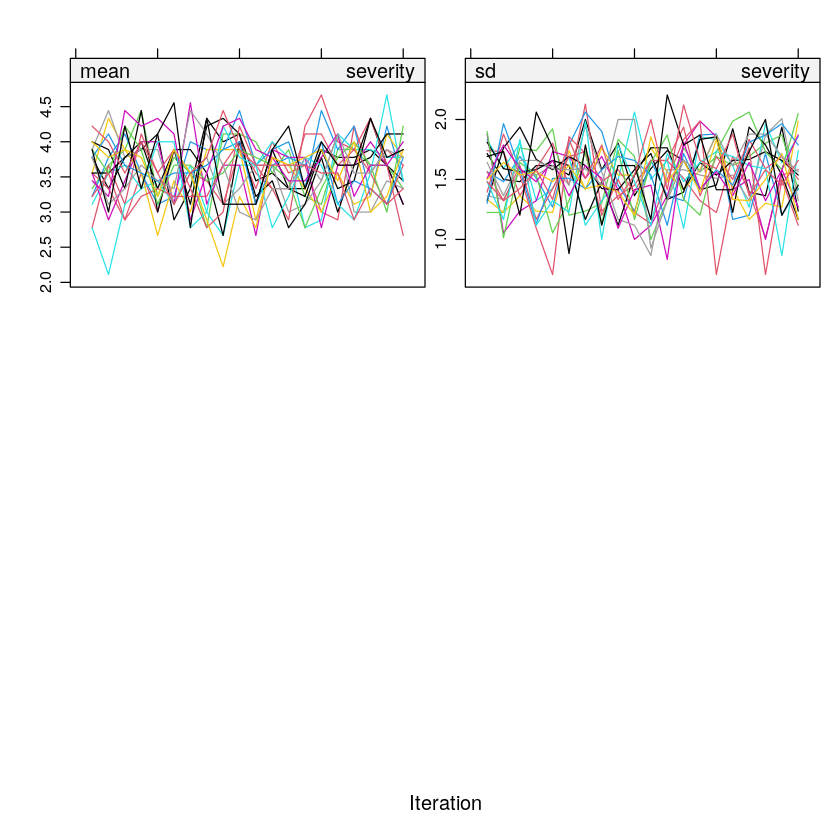

In [49]:
plot(mi_male_data)

In [50]:
mi_model = build_linear_model(mi_male_data)
summary(pool(mi_model))

term,estimate,std.error,statistic,df,p.value
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.85054543,0.59241065,4.8117727,95.71517,5.572742e-06
phydisab,-0.04766318,0.05165910,-0.9226482,105.82317,3.582894e-01
psydisab,0.14514522,0.05623396,2.5810956,91.24415,1.144333e-02


#### Maximum Likelihood Estimation

In [51]:
em_results = em(raw_male_data, cols=c('depress','phydisab','psydisab'))
em_results

1.00000000,0.02420851,0.2169932
0.02420851,1.00000000,0.4792311
0.21699323,0.47923106,1.0000000


### Results
#### Listwise Deletion

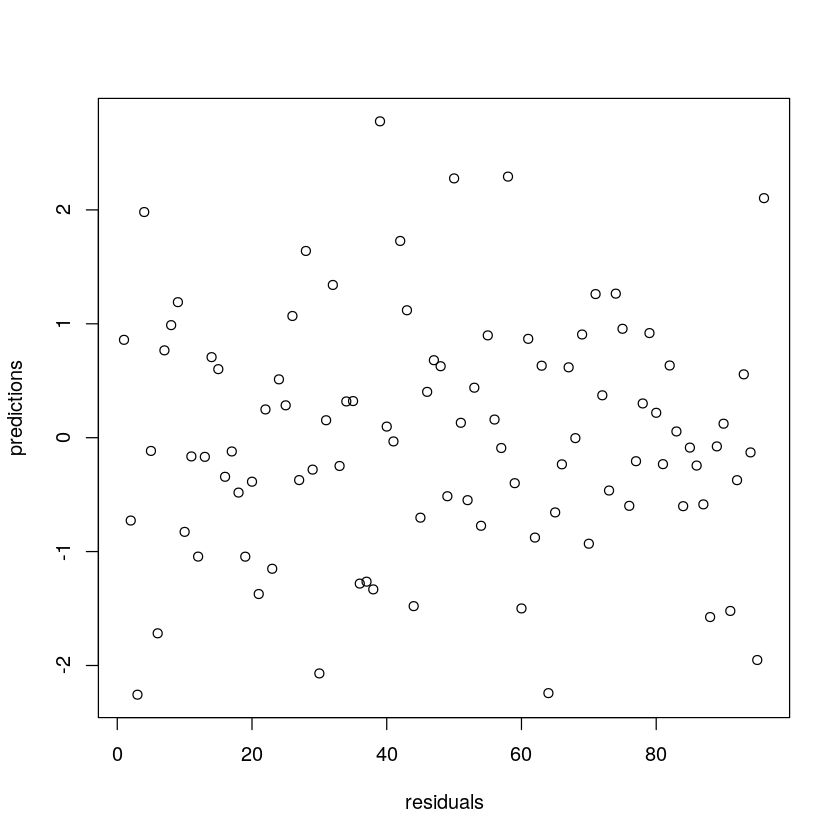

In [52]:
plot_residuals(complete_case_model)

#### Multiple Imputation

In [53]:
pool.r.squared(mi_model,adjusted=TRUE)

,est,lo 95,hi 95,fmi
adj R^2,0.0460632,0.000528745,0.1529125,0.2081025


In [54]:
tidy(pool(mi_model),conf.int=TRUE)

term,estimate,std.error,statistic,p.value,conf.low,conf.high,b,df,dfcom,fmi,lambda,m,riv,ubar
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
(Intercept),2.85054543,0.59241065,4.8117727,5.572742e-06,1.6745749,4.02651594,0.0483089559,95.71517,127,0.1618664,0.1445344,20,0.1689541,0.300225977
phydisab,-0.04766318,0.05165910,-0.9226482,3.582894e-01,-0.1500843,0.05475799,0.0002588413,105.82317,127,0.1183493,0.1018425,20,0.1133905,0.002396879
psydisab,0.14514522,0.05623396,2.5810956,1.144333e-02,0.0334474,0.25684304,0.0004916214,91.24415,127,0.1809959,0.1632386,20,0.1950838,0.002646055


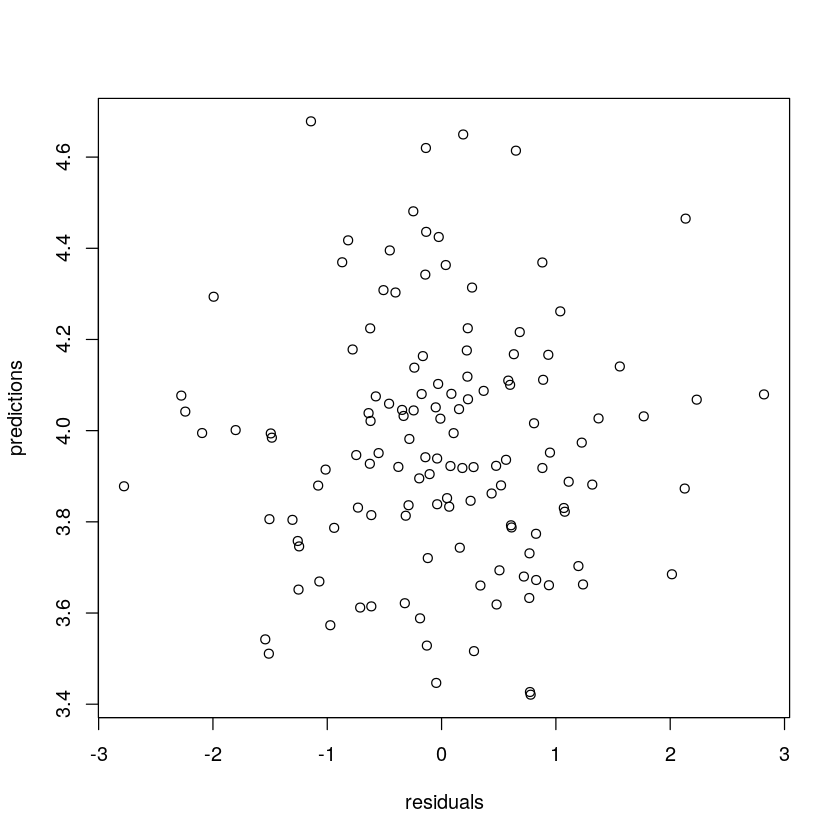

In [55]:
plot_residuals(mi_model, multiple_datasets=TRUE)

#### Maximum Likelihood Estimation

In [56]:
em_model_coeffs = coeff_em(raw_male_data, em_results, 1, predictor_cols=c(2,3),offset=1)
em_model_coeffs

,coeffs
,<dbl>
(Intercept),2.95152771
psydisab,-0.05132739
severity,0.13815796


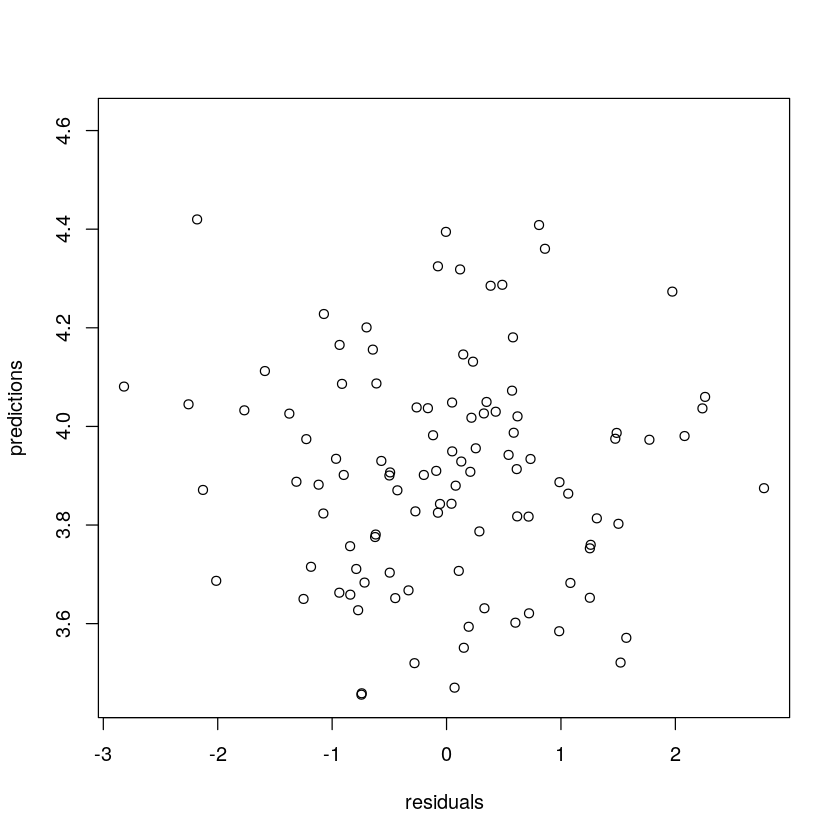

In [57]:
em_model_predictions = em_model_coeffs$coeffs[1] +
    em_model_coeffs$coeffs[2]*raw_male_data$phydisab +
    em_model_coeffs$coeffs[3]*raw_male_data$psydisab
em_model_residuals = em_model_predictions - raw_male_data$depress

plot(em_model_residuals,em_model_predictions,
     xlab='residuals',ylab='predictions')